# 합성곱 신경망

이 튜토리얼은 MNIST 숫자를 분류하기 위해 간단한 [합성곱 신경망](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network)(Convolutional Neural Network, CNN)을 훈련합니다. 간단한 이 네트워크는 MNIST 테스트 세트에서 99% 정확도를 달성할 것입니다. 이 튜토리얼은 [케라스 Sequential API](https://www.cs.toronto.edu/~kriz/cifar.html)를 사용하기 때문에 몇 줄의 코드만으로 모델을 만들고 훈련할 수 있습니다.


### 텐서플로 임포트하기

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# device 설정: GPU가 사용 가능하면 GPU를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### MNIST 데이터셋 다운로드하고 준비하기

CIFAR10 데이터세트에는 10개 클래스에 60,000개의 컬러 이미지가 포함되어 있으며 각 클래스에는 6,000개의 이미지가 있습니다. 이 데이터세트는 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 나뉩니다. 클래스는 상호 배타적이며 서로 겹치지 않습니다.

In [7]:
# CIFAR10 데이터셋은 torchvision에서 제공하며, transforms.ToTensor()를 사용하면 픽셀값이 [0, 1]로 정규화됩니다.
transform = transforms.ToTensor()

# 학습 데이터와 테스트 데이터 다운로드 및 로드
trainset = torchvision.datasets.CIFAR10(root='./CIFAR10data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./CIFAR10data', train=False, download=True, transform=transform)

# DataLoader를 사용하여 배치 단위로 데이터를 불러옵니다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:12<00:00, 13.9MB/s] 


### 데이터 확인하기

데이터세트가 올바른지 확인하기 위해 훈련 세트의 처음 25개 이미지를 플로팅하고 각 이미지 아래에 클래스 이름을 표시해 보겠습니다.


In [8]:
# CIFAR10 클래스 이름 리스트
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

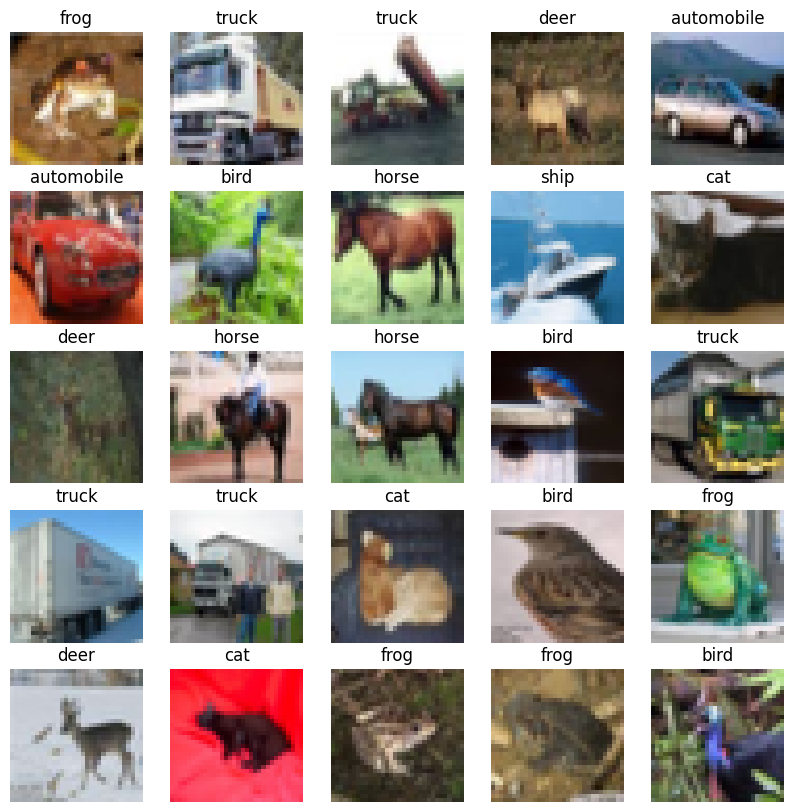

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # trainset에서 i번째 이미지와 라벨 가져오기
    img, label = trainset[i]
    # PyTorch Tensor는 (C, H, W) 형식이므로 (H, W, C)로 변환하여 출력
    img = img.numpy().transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis('off')
plt.show()

### 합성곱 층 만들기

아래 6줄의 코드에서 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의합니다.

입력으로 CNN은 배치 크기를 무시하고 형상(image_height, image_width, color_channels)의 텐서를 사용합니다. 이러한 차원을 처음 접하는 경우 color_channels는 (R,G,B)를 나타냅니다. 이 예에서는 CIFAR 이미지 형식인 형상(32, 32, 3)의 입력을 처리하도록 CNN을 구성합니다. `input_shape` 인수를 첫 번째 레이어에 전달하여 이를 수행할 수 있습니다.


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 첫 번째 Convolution 레이어: 입력 채널 3, 출력 채널 32, 커널 크기 3x3 (패딩 없음)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        # Max Pooling 레이어: 윈도우 크기 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 두 번째 Convolution 레이어: 입력 채널 32, 출력 채널 64, 커널 크기 3x3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        # 세 번째 Convolution 레이어: 입력 채널 64, 출력 채널 64, 커널 크기 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        # Fully Connected 레이어: 
        # conv3의 출력 특징맵 크기는 (N, 64, 4, 4)로 예상 (32->30 -> 15 -> 13 -> 6 -> 4)
        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=64)
        # 최종 출력 레이어: 10개의 클래스
        self.fc2 = nn.Linear(in_features=64, out_features=10)
        # 활성화 함수 ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        # 첫 번째 Convolution + ReLU + Max Pooling
        x = self.pool(self.relu(self.conv1(x)))    # 출력 크기: (32-3+1)=30 -> 30/2=15
        # 두 번째 Convolution + ReLU + Max Pooling
        x = self.pool(self.relu(self.conv2(x)))      # 출력 크기: (15-3+1)=13 -> 13/2=6 (정수 나눗셈)
        # 세 번째 Convolution + ReLU
        x = self.relu(self.conv3(x))                 # 출력 크기: (6-3+1)=4
        # 특징 맵을 1차원으로 평탄화 (flatten)
        x = x.view(-1, 64 * 4 * 4)
        # 첫 번째 Fully Connected 레이어 + ReLU
        x = self.relu(self.fc1(x))
        # 출력 레이어 (로짓을 출력하므로 softmax는 적용하지 않습니다.)
        x = self.fc2(x)
        return x

지금까지 모델의 아키텍처를 표시해 보겠습니다.

In [11]:
# 모델 생성 후 device로 이동
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


### 손실 함수와 최적화 알고리즘 정의

In [12]:
# CrossEntropyLoss는 내부적으로 softmax를 포함하므로 출력 로짓을 그대로 사용합니다.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 모델 학습 및 검증

In [13]:
num_epochs = 10  # 학습 에폭 수 설정

# 에폭별 정확도 기록을 위한 리스트
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 전환
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 학습 데이터에 대해 반복
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()           # 기울기 초기화
        outputs = model(inputs)         # 순전파(forward pass)
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()                 # 역전파(backward pass)
        optimizer.step()                # 가중치 업데이트
        
        running_loss += loss.item()
        # 예측값 계산
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = correct / total
    train_accuracy_history.append(train_acc)
    
    # 검증 단계 (테스트 데이터셋을 사용)
    model.eval()  # 평가 모드로 전환 (dropout, batchnorm 등이 비활성화됨)
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_acc = correct_val / total_val
    val_accuracy_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10, Loss: 1.6766, Train Acc: 0.3780, Val Acc: 0.4642
Epoch 2/10, Loss: 1.3735, Train Acc: 0.5024, Val Acc: 0.5333
Epoch 3/10, Loss: 1.2363, Train Acc: 0.5563, Val Acc: 0.5685
Epoch 4/10, Loss: 1.1389, Train Acc: 0.5956, Val Acc: 0.6082
Epoch 5/10, Loss: 1.0723, Train Acc: 0.6205, Val Acc: 0.6206
Epoch 6/10, Loss: 1.0018, Train Acc: 0.6474, Val Acc: 0.6506
Epoch 7/10, Loss: 0.9530, Train Acc: 0.6644, Val Acc: 0.6372
Epoch 8/10, Loss: 0.9060, Train Acc: 0.6823, Val Acc: 0.6750
Epoch 9/10, Loss: 0.8641, Train Acc: 0.6967, Val Acc: 0.6774
Epoch 10/10, Loss: 0.8292, Train Acc: 0.7080, Val Acc: 0.6768


### 학습 결과 그래프로 출력

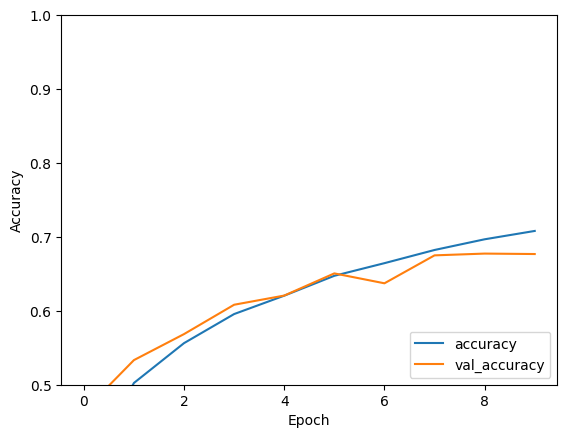

In [14]:
plt.plot(train_accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

### 테스트 데이터셋으로 최종 평가

In [15]:
model.eval()  # 평가 모드로 전환
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_acc = correct_test / total_test
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6768
